# Clustering users

## Import

In [16]:
# %load basic
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_columns',200)
pd.options.display.float_format = '{:.2f}'.format
BASE_DIR = '/Users/efraflores/Desktop/EF/Corner/Clustering/data'
sorted(os.listdir(BASE_DIR))

['PG_985.csv']

In [17]:
df = pd.read_csv(os.path.join(BASE_DIR,'PG_985.csv')).dropna()
df.sample(4)

,user_id,membership,year_week,lat,lng,total_products,total_receipt,filtered_orders,filtered_products,filtered_receipt
145,1996198,False,2021-16,19.41,-99.16,26,1570.86,1,1,48.90
0,4290,True,2021-16,19.39,-99.27,40,2836.37,1,1,29.90
48,249582,True,2021-16,19.43,-99.21,5,108.63,1,1,39.90
120,1120624,False,2021-16,19.41,-99.25,37,2389.05,1,1,37.90


## Functions

In [18]:
import time
import numpy as np
from IPython.lib.display import Audio

start = time.time()
def time_exp(x):
    minutes, seconds = np.floor(x/60), 60*(x/60-np.floor(x/60))
    print(f"{'{:.0f}'.format(minutes)} minutos con {'{:.2f}'.format(seconds)} segundos")
    
def tono(a = 1000, b = 700, play_time_seconds = 1, framerate = 4410):
    t = np.linspace(0, play_time_seconds, framerate*play_time_seconds)*np.pi
    return Audio(np.sin(a*t) + np.sin(b*t), rate = framerate, autoplay=True)

In [19]:
def perc70(x):
    return np.percentile(x,70)

In [20]:
from sklearn.ensemble import IsolationForest

def outliers(df,cols):
    outlier = IsolationForest(contamination=.055,n_jobs=-1)
    df['outlier'] = outlier.fit_predict(df[cols])
    df = df[df['outlier']!=-1].drop(columns = 'outlier')
    return df

In [21]:
import pygal
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score, silhouette_samples

def koptimo(df):
    sse,db,slc = {}, {}, {}
    for k in range(2, 16):
        kmeans = KMeans(n_clusters = k, max_iter= 100, random_state = 22).fit(df)
        if k == 3: labels = kmeans.labels_
        clusters = kmeans.labels_
        sse[k] = kmeans.inertia_ 
        db[k] = davies_bouldin_score(df, clusters)
        slc[k] = silhouette_score(df, clusters)

    dicts = [sse,db,slc]

    for dicc in dicts:
        min_value = min(list(dicc.values()))
        max_value = max(list(dicc.values()))
        for k in dicc.keys():
            dicc[k] = (dicc[k] - min_value + 1)/(max_value - min_value + 1)

    line_chart = pygal.Line()
    line_chart.title = 'K-óptimo'
    line_chart.x_labels = map(str, sse.keys())
    for name, dicc in zip(['Inertia','DB','Silhouette'],dicts):
        line_chart.add(name, list(map(lambda x: round(x,2), dicc.values())))
    display(line_chart)

In [22]:
import string
import warnings
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import MinMaxScaler

warnings.filterwarnings('ignore')

def clustering(df,
               cols,
               n_clusters=5,
               #bubble_size=100,
               kmeans=False):
    df = df.copy()
    mm_df = MinMaxScaler()
    Xs = pd.DataFrame(mm_df.fit_transform(df[cols]), 
                      index = df.index,
                      columns = cols)
    
    cluster = (KMeans(n_clusters, random_state=22) if kmeans 
               else GaussianMixture(n_clusters, random_state=22))
    Xs['cluster'] = cluster.fit_predict(Xs)
    
    dict_cluster = dict(enumerate(string.ascii_uppercase[:n_clusters]))
    df['cluster'] = Xs['cluster'].map(dict_cluster) 
    print(f'Distribución de registros en los {n_clusters} clústeres')
    display(df['cluster'].value_counts(1).reset_index().sort_values(by='index'))

    #Ahora con sólo dos componentes en PCA para apreciar gráficamente
    pca = PCA(2)
    pipe_pca = Pipeline(steps=[('MinMax', mm_df),('PCA', pca)])
    Xg = pd.DataFrame(pipe_pca.fit_transform(df.iloc[:,:-1]), 
                      index = df.index,
                      columns = ['p1','p2'])
    Xg['cluster'] = df['cluster'].copy()
    print(f'Varianza explicada con 2dim: {round(pca.explained_variance_ratio_.sum(),4)}')
    
    #Bubbleplot separando por color cada clúster
    plt.figure(figsize=(10,6))
    sns.scatterplot(data=Xg.sort_values(by='cluster'),
                    x='p1',
                    y='p2',
                    #size=bubble_size,
                    #sizes=(20,500),
                    alpha=0.5,
                    hue='cluster', 
                    palette = 'Paired')
    #La leyenda estará fuera de la gráfica
    plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)
    plt.show();
    
    return df

In [23]:
import seaborn as sns

def perfilamiento(df,cols='',cluster='cluster'):
    n_clusters = len(set(df[cluster]))
    
    if cols=='':
        cols=df.columns
        aux = df[cols].groupby(cluster).mean()
        for col in aux.columns:
            aux[col] = aux[col]/aux[col].sum()

        fig = plt.figure()
        fig, ax = plt.subplots(figsize=(int(n_clusters/1.5),max(1,int(len(aux.columns)/5))))
        fig.patch.set_facecolor('white')
        fig.patch.set_alpha(0.9)
        sns.heatmap(aux.transpose(), cmap = 'Blues')
        plt.show();
        
    else:
        for col in cols:
            aux = df.copy()
            aux['n'] = 1
            aux = aux.pivot_table(index=cluster,
                                  columns=col,
                                  values='n',
                                  aggfunc='count',
                                  fill_value=0)
            for columna in aux.columns:
                aux[columna] = aux[columna]/aux[columna].sum()

            fig = plt.figure()
            fig, ax = plt.subplots(figsize=(int(n_clusters/1.5),max(1,int(len(set(df[col]))/4))))
            fig.patch.set_facecolor('white')
            fig.patch.set_alpha(0.9)
            sns.heatmap(aux.transpose(), cmap = 'Blues')
            plt.show();

## Transform

In [24]:
for m in ['total','filtered']:
    df[f'{m}_ticket'] = df[f'{m}_receipt'] / df[f'{m}_products']

df.sample(4)

,user_id,membership,year_week,lat,lng,total_products,total_receipt,filtered_orders,filtered_products,filtered_receipt,total_ticket,filtered_ticket
92,650310,True,2021-16,19.43,-99.18,24,1457.75,1,1,55.90,60.74,55.90
66,403880,False,2021-16,19.42,-99.26,50,2062.90,1,1,29.90,41.26,29.90
125,1311800,True,2021-16,19.37,-99.28,35,1130.86,1,1,37.90,32.31,37.90
70,464017,True,2021-16,19.49,-99.14,60,3478.31,1,1,39.00,57.97,39.00


In [25]:
df = df.pivot_table(index=['user_id','membership','lat','lng'],columns='year_week',values=df.columns[5:],aggfunc=['sum','mean','median',perc70])
df.columns = [y+'_'+z+'_'+x for x,y,z in df.columns]
df = df[sorted(df.columns)].copy()
df = df.reset_index().set_index('user_id')
df.sample(4)

,membership,lat,lng,filtered_orders_2021-16_mean,filtered_orders_2021-16_median,filtered_orders_2021-16_perc70,filtered_orders_2021-16_sum,filtered_products_2021-16_mean,filtered_products_2021-16_median,filtered_products_2021-16_perc70,filtered_products_2021-16_sum,filtered_receipt_2021-16_mean,filtered_receipt_2021-16_median,filtered_receipt_2021-16_perc70,filtered_receipt_2021-16_sum,filtered_ticket_2021-16_mean,filtered_ticket_2021-16_median,filtered_ticket_2021-16_perc70,filtered_ticket_2021-16_sum,total_products_2021-16_mean,total_products_2021-16_median,total_products_2021-16_perc70,total_products_2021-16_sum,total_receipt_2021-16_mean,total_receipt_2021-16_median,total_receipt_2021-16_perc70,total_receipt_2021-16_sum,total_ticket_2021-16_mean,total_ticket_2021-16_median,total_ticket_2021-16_perc70,total_ticket_2021-16_sum
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
118698,False,19.43,-99.17,1,1,1,1,1,1,1,1,48.90,48.90,48.90,48.90,48.90,48.90,48.90,48.90,19,19,19,19,2307.16,2307.16,2307.16,2307.16,121.43,121.43,121.43,121.43
251614,True,19.33,-99.23,1,1,1,1,1,1,1,1,61.50,61.50,61.50,61.50,61.50,61.50,61.50,61.50,22,22,22,22,2325.73,2325.73,2325.73,2325.73,105.72,105.72,105.72,105.72
1749834,True,19.37,-99.16,1,1,1,1,1,1,1,1,37.90,37.90,37.90,37.90,37.90,37.90,37.90,37.90,15,15,15,15,1621.19,1621.19,1621.19,1621.19,108.08,108.08,108.08,108.08
294824,True,19.36,-99.19,1,1,1,1,1,1,1,1,48.90,48.90,48.90,48.90,48.90,48.90,48.90,48.90,18,18,18,18,2374.28,2374.28,2374.28,2374.28,131.90,131.90,131.90,131.90


In [26]:
df = outliers(df,df.columns)

## Clustering

Distribución de registros en los 7 clústeres


,index,cluster
0,A,0.24
2,B,0.16
3,C,0.13
5,D,0.12
6,E,0.02
4,F,0.13
1,G,0.21


Varianza explicada con 2dim: 0.5262


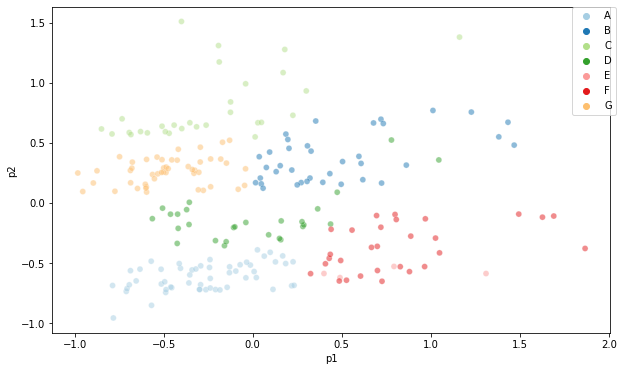

In [28]:
df = clustering(df,df.columns,7,kmeans=True)

<Figure size 432x288 with 0 Axes>

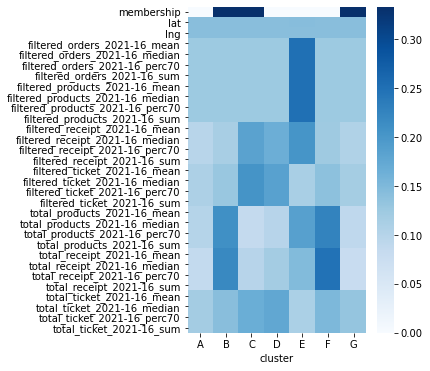

In [29]:
perfilamiento(df)

## Fin

In [14]:
time_exp(time.time()-start)
tono()

0 minutos con 2.06 segundos
